In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy

Want to show a connection between the prierarchy idea and the composability of LMDPs.

$$
\begin{align}
v(s) &= \mathop{\text{min}}_a \big[ r(s, a) + \mathop{\mathbb E}_{x' \sim p(\cdot | x, a)} v(x') \big]\\
p_i(x' | x) &= \tau(x' | x, \pi_i(x)) \\
r(s, a) &= q(x) +  \mathop{\mathbb E}_{x'\sim a(\cdot | x)} \log \frac{a(x' | x)}{p(x' | x)} - \sum_{i=1}^k \mathop{\mathbb E}_{x'\sim a(\cdot | x)} \log p_i(x' | x) \\
&= q(x) +  \mathop{\mathbb E}_{x'\sim a(\cdot | x)} \log \frac{a(x' | x)}{p(x' | x)\prod_{i=1}^k p_i(x' | x)} \\
\end{align}
$$

These priors maybe added sequential as training progresses.

$$
\begin{align}
-log(x) &= q(x) + \mathop{\text{min}}_a \big[\mathop{\mathbb E}_{x'\sim a(\cdot | x)} \log \frac{a(x' | x)}{z(x')p(x' | x)\prod_{i=1}^k p_i(x' | x)}\big]\\
\end{align}
$$

???

$$
\begin{align}
d(\cdot | x) &= \prod_{i=1}^k p_i(x' | x) \\
a^{* }(x' | x) &= \frac{p(x' | x)z(x')d(\cdot | x)}{G[z](x)} \\
G[z](x) &= \mathop{\mathbb E}_{x'\sim p(\cdot | x)d(\cdot | x)} z(x') \\
&=  \mathop{\mathbb E}_{x'\sim d(\cdot | x)} \mathop{\mathbb E}_{x'\sim p(\cdot | x)}z(x') \\
z_k(x) &:= \mathop{\mathbb E}_{x'\sim p(\cdot | x)p_k(\cdot | x)}z(x') \\
G[z](x) &= \sum_k w_k z_k(x') \\
z(x) &= e^{-q(x)}G[z](x) \\
\end{align}
$$


Want to find a relationship to this.
http://papers.nips.cc/paper/3842-compositionality-of-optimal-control-laws.pdf


In [4]:
# utils
def onehot(idx, N): # hacky. i know...
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def sample(x, logits):
    # or could use gumbel trick
    p = softmax(logits)
    return np.random.choice(x, p=p)

def entropy(z):
    p = softmax(z)
    return -np.sum(p*np.log(p)/np.log(n_actions))

class Env():
    def __init__(self, n_states, n_actions):
        """
        Args:
            n_states (int): the number of states
            n_actions (int): the number of action
        """
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)

        # each action move from state(i) to state(j) with probability close to 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)

    def new_task(self):
        self.R = onehot(np.random.randint(0, n_states), n_states)

In [5]:
class TabularSARSA():
    def __init__(self, n_states, n_actions):
        self.gamma = 0.999
        self.lr = 0.1

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def choose_action(self, s, r):
        a = sample(np.arange(n_actions), self.qs[s, ...])
        # should change to epsilon greedy or entropy regularised
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def __call__(self, s):
        return softmax(self.qs[s, ...])
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!
        self.qs -= 1e-4 * (self.qs-np.mean(self.qs, axis=1, keepdims=True))  # a form of entropy regularisation

In [6]:
def play_episode(env, player, len_episode):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    w = np.random.randint(8)
    
    # play an episode
    for _ in range(len_episode):
        a = player.choose_action(s, r)
        s, r = env.step(s, a)
        total_r += r
        
    return total_r/len_episode

In [7]:
n_actions = 12
n_states = 3
env = Env(n_states, n_actions)
player = TabularSARSA(n_states, n_actions)

play_episode(env, player, 1000)

0.809

In [202]:
def recursive_action_choice(heirarchy, x):
    # want to keep track of which policies are getting called
    # and how much
    a = heirarchy[0](x)
    if len(heirarchy) == 1:
        return a
    elif entropy(a) < n_actions//2:
        return a
    else:
        return recursive_action_choice(heirarchy[1:], x)
    



class Heirarchy():
    """
    Residual policy learning.
    Learn to act when uncertain.
    
    
    What if each policy were trained at different discounts!?
    The first one with low discount.
    The next one with higher.
    ...?
    """
    def __init__(self, n_states, n_actions):
        self.n_actions = n_actions
        self.policies = [TabularSARSA(n_states, n_actions)]
        self.record = []
        self.step = 0
        
    def choose_action(self, s, r):
        # want to keep track of which policies are getting called
        # and how much
        certain = False
        counter = 0
        while not certain and (counter < len(self.policies)):
            pi = self.policies[counter]
            
            p_a = pi(s)
            pi.choose_action(s, r)
            if entropy(p_a) < self.n_actions // 10 or (len(self.policies)-1 == counter):
                certain = True
            
            # track which policies are being used
            self.record.append(counter)
            counter += 1
        
        a = sample(np.arange(self.n_actions), p_a)
        
        # only train the latest policy.
        if self.step % 1000 == 0 and self.step > 0:
            self.policies.append(TabularSARSA(n_states, n_actions))
        self.policies[-1].choose_action(s, r)
        
        self.step += 1
        
        return a

In [203]:
n_actions = 3
n_states = 128
env = Env(n_states, n_actions)
player = Heirarchy(n_states, n_actions)

In [223]:

play_episode(env, player, 1000)

0.01

(array([9000., 7999., 6999., 5999.,    0., 4999., 3999., 2999., 1999.,
         999.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

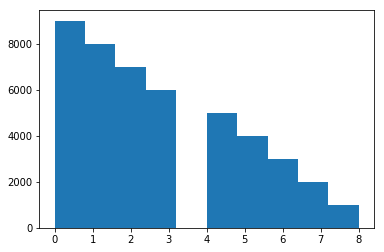

In [221]:
plt.hist(player.record)

In [201]:
len(player.policies)

27

In [ ]:
# damn. lower level policies are certain when they shouldnt be...
# also the value changes.